## Fourier transform

In [1]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = '../Data/train.csv'  # Update this with your file path
data = pd.read_csv(file_path)


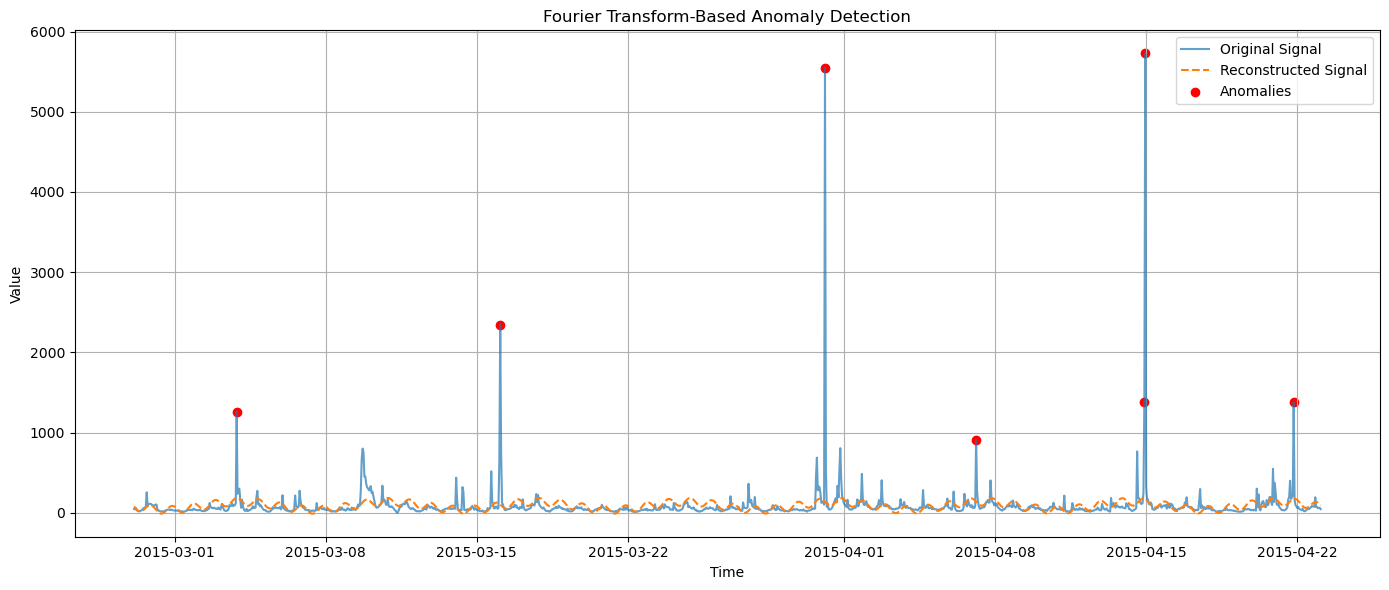

In [2]:
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

# Convert timestamp to datetime and set as index
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data.set_index('timestamp', inplace=True)

# Resample to ensure even spacing (e.g., hourly) and fill missing values
data_resampled = data['value'].resample('1h').mean().interpolate()

# Apply FFT
fft_values = fft(data_resampled)
frequencies = fftfreq(len(data_resampled), d=1)  # d=1 assumes hourly intervals

# Retain only dominant frequencies
magnitude = np.abs(fft_values)
dominant_indices = magnitude > (0.2 * max(magnitude))  # Retain frequencies with significant magnitude
fft_filtered = np.where(dominant_indices, fft_values, 0)

# Reconstruct the signal using filtered FFT
reconstructed_signal = np.real(ifft(fft_filtered))

# Calculate residuals
residuals = data_resampled - reconstructed_signal

# Detect anomalies (residual threshold)
threshold = 3 * np.std(residuals)
anomalies = np.abs(residuals) > threshold

# Plot the original, reconstructed signal, and anomalies
plt.figure(figsize=(14, 6))
plt.plot(data_resampled.index, data_resampled, label='Original Signal', alpha=0.7)
plt.plot(data_resampled.index, reconstructed_signal, label='Reconstructed Signal', linestyle='dashed')
plt.scatter(data_resampled.index[anomalies], data_resampled[anomalies], color='red', label='Anomalies')
plt.title('Fourier Transform-Based Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Error Analysis:
{'True Positives': np.int64(0), 'False Positives': np.int64(0), 'False Negatives': np.int64(776), 'True Negatives': np.int64(15054)}


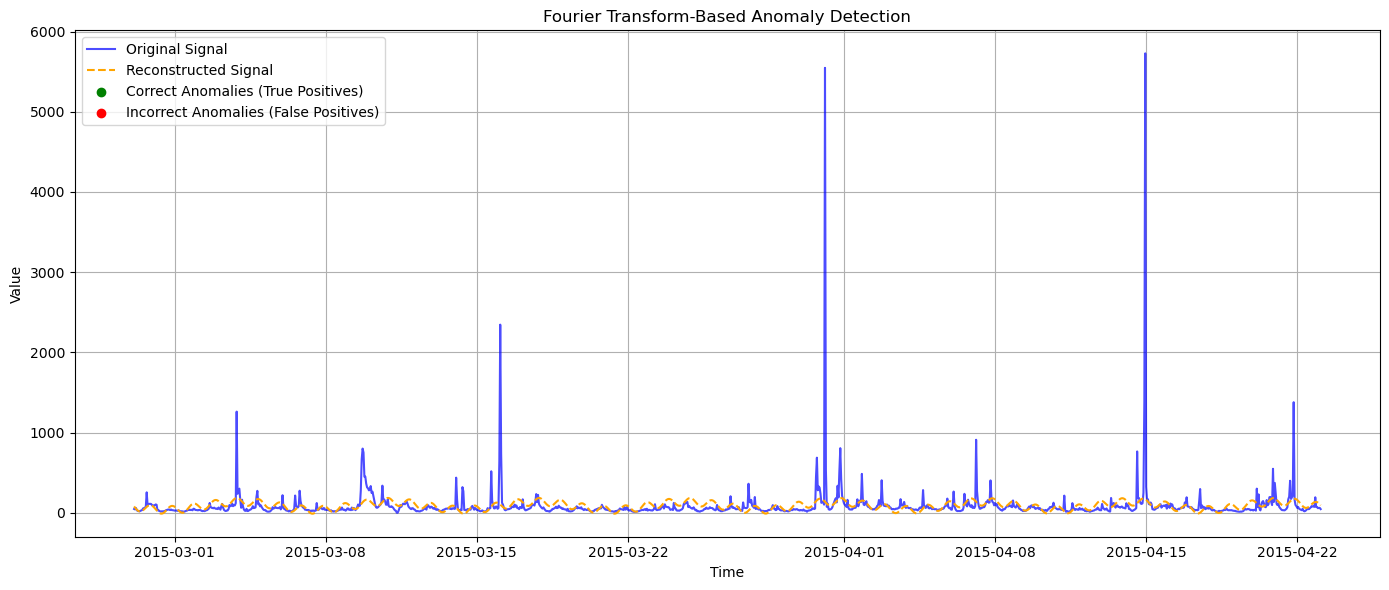

In [3]:

# Add anomaly labels for evaluation
data['predicted_anomaly'] = anomalies.reindex(data.index, fill_value=False)

# Analyze anomalies
true_positive = data['is_anomaly'] & data['predicted_anomaly']
false_positive = ~data['is_anomaly'] & data['predicted_anomaly']
false_negative = data['is_anomaly'] & ~data['predicted_anomaly']

error_analysis = {
    "True Positives": true_positive.sum(),
    "False Positives": false_positive.sum(),
    "False Negatives": false_negative.sum(),
    "True Negatives": (~data['is_anomaly'] & ~data['predicted_anomaly']).sum(),
}

print("Error Analysis:")
print(error_analysis)

# Visualization of anomalies
plt.figure(figsize=(14, 6))

# Plot original signal
plt.plot(data_resampled.index, data_resampled, label='Original Signal', color='blue', alpha=0.7)

# Plot reconstructed signal
plt.plot(data_resampled.index, reconstructed_signal, label='Reconstructed Signal', linestyle='dashed', color='orange')

# Highlight correct anomalies (True Positives)
true_positive = data['is_anomaly'] & data['predicted_anomaly']
plt.scatter(
    data.index[true_positive],
    data['value'][true_positive],
    color='green',
    label='Correct Anomalies (True Positives)',
    zorder=5
)

# Highlight incorrect anomalies (False Positives)
false_positive = ~data['is_anomaly'] & data['predicted_anomaly']
plt.scatter(
    data.index[false_positive],
    data['value'][false_positive],
    color='red',
    label='Incorrect Anomalies (False Positives)',
    zorder=5
)

# Add labels and legend
plt.title('Fourier Transform-Based Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Analysis of False Negatives

The high number of false negatives in the anomaly detection results can be attributed to several factors:

1. **Threshold Setting**: What ever the threshold is set to, it is not able to capture the anomalies in the data.

3. **Data Resampling**: The data is resampled to an hourly frequency and interpolated to fill missing values. This resampling might smooth out some of the anomalies, making them harder to detect. Analyzing the data at its original frequency or using a different resampling method might help.

4. **Model Limitations**: The STL decomposition might not be the best model for this specific dataset. Other anomaly detection methods, such as machine learning-based approaches, might perform better in identifying anomalies.

5. **Data Quality**: The quality of the input data can significantly impact the results. If there are inconsistencies, noise, or missing values in the data, it can lead to inaccurate anomaly detection. Ensuring data quality through preprocessing steps can improve the results.

6. **Anomaly Definition**: The definition of what constitutes an anomaly might need to be revisited. If the criteria for labeling anomalies are too strict or not well-defined, it can lead to a high number of false negatives.